In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os
import pickle
import torch
from torch import nn
import torch.multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from rollout import Rollout
from controller import Controller

device = torch.device('cpu')
mp.set_start_method('spawn')

In [2]:
frames = np.load("data/frames.npy")
frames = frames.reshape(frames.shape[0], -1)
frames = frames / 255
frames = frames.astype(np.float64)
print(frames.shape)

(10000, 27648)


In [3]:
try:
    with open("modelsv2/vision.model", 'rb') as file:
        pca = pickle.load(file)
except FileNotFoundError:
    pca = PCA(n_components=297)
    pca.fit(frames)
    with open("modelsv2/vision.model", 'wb') as file:
        pickle.dump(pca, file)

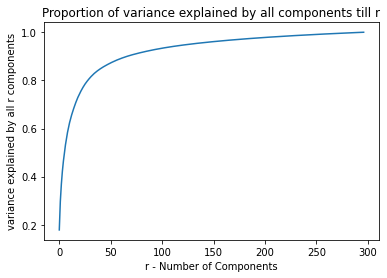

In [4]:
plt.plot(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_))
plt.title("Proportion of variance explained by all components till r")
plt.xlabel("r - Number of Components")
plt.ylabel("variance explained by all r components")
plt.show()

In [5]:
restore = True
nodes = 300
if restore:
    cont = torch.load("modelsv2/controller-best-v2.pt")
else:
    cont = Controller(nodes)
cont.to(device)
cont.share_memory()
cont.eval()

cont.__name__ = 'global'

In [6]:
curr_best_score  = curr_mean_score = 0

In [7]:
from collections import OrderedDict 

NUM_GENERATION = 100
NUM_AVERAGE_REWARD_OVER = 4

def param2numpy(model):
    params = model.parameters()
    w = next(params) # shape 3xnodes
    b = next(params) # shape 3
    flat = torch.cat([w.flatten(), b], dim=-1)
    return flat.detach().cpu().numpy()

def load_param(model, params):
    split = nodes * 3
    w, b = params[:split], params[split:]
    w, b = [torch.tensor(i).to(device) for i in (w, b)]
    w = w.reshape(3, nodes)
    updated_dict = OrderedDict({"fc.weight":w, "fc.bias":b})
    model.load_state_dict(updated_dict)

def get_reward_for_solution(soln):
    average_over = 4
    global cont
    global pca
    load_param(cont, soln)
    cont.double()
    
    pool = mp.Pool(processes=4)
    rewards = pool.starmap(Rollout, [[pca, cont, False] for i in range(average_over)])
    pool.close()

    return -np.mean(rewards).item()

In [8]:
import cma
es = cma.CMAEvolutionStrategy(param2numpy(cont), 0.09)

(12_w,24)-aCMA-ES (mu_w=7.0,w_1=24%) in dimension 903 (seed=1017749, Wed Dec  2 18:07:19 2020)


In [9]:
for generation in range(10, NUM_GENERATION):
    assert cont.__name__ == 'global'

    print("Generation:: {}..".format(generation + 1))
    solutions = es.ask(48)

    function_values = [get_reward_for_solution(s) for s in solutions]

    if -min(function_values) > curr_best_score:
        curr_best_score = -min(function_values)
        torch.save(cont, "modelsv2/controller-best-v2.pt")
        print("Best saved with reward {}".format(-min(function_values)))

    if generation%10==0:
        torch.save(cont, "modelsv2/controller-generation-{}-v2.pt".format(generation))
        print("Model saved as: modelsv2/controller-generation-{}-v2.pt".format(generation))

    es.tell(solutions, function_values)
    es.logger.add()
    es.disp()

torch.save(cont, "models/controller-generation-last")

Generation:: 11..
Best saved with reward 331.25256941646387
Model saved as: modelsv2/controller-generation-10-v2.pt
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     24 -3.312525694164639e+02 1.0e+00 8.92e-02  9e-02  9e-02 38:12.0
Generation:: 12..
Best saved with reward 427.50984557206857
    2     48 -4.275098455720686e+02 1.0e+00 8.85e-02  9e-02  9e-02 76:26.1
Generation:: 13..
    3     72 -4.037836025126292e+02 1.0e+00 8.79e-02  9e-02  9e-02 114:50.7
Generation:: 14..
Best saved with reward 521.358216519294
    4     96 -5.213582165192940e+02 1.0e+00 8.73e-02  9e-02  9e-02 153:13.7
Generation:: 15..
Best saved with reward 533.25835560361
    5    120 -5.332583556036100e+02 1.0e+00 8.67e-02  9e-02  9e-02 191:36.6
Generation:: 16..
Best saved with reward 655.1236473980032
    6    144 -6.551236473980032e+02 1.0e+00 8.61e-02  9e-02  9e-02 229:28.7
Generation:: 17..
    7    168 -5.527597283723799e+02 1.0e+00 8.56e-02  9e-02  9e-02 267:43.1
Generation::

KeyboardInterrupt: 

In [14]:
load_param(cont, es.result[0])
torch.save(cont, "modelsv2/controller-best-v2.pt")